## Step 0: Load The Data

In [23]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import cv2

training_file = 'traffic-signs-data/train.p'
validation_file = 'traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

## Step 1: Dataset Summary & Exploration 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [24]:
n_train = X_train.shape[0]
n_validation = X_valid.shape[0]
n_test = X_test.shape[0]
image_shape = X_train.shape[1:]
n_classes = max(y_test) - min(y_test)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 42


### Include an exploratory visualization of the dataset

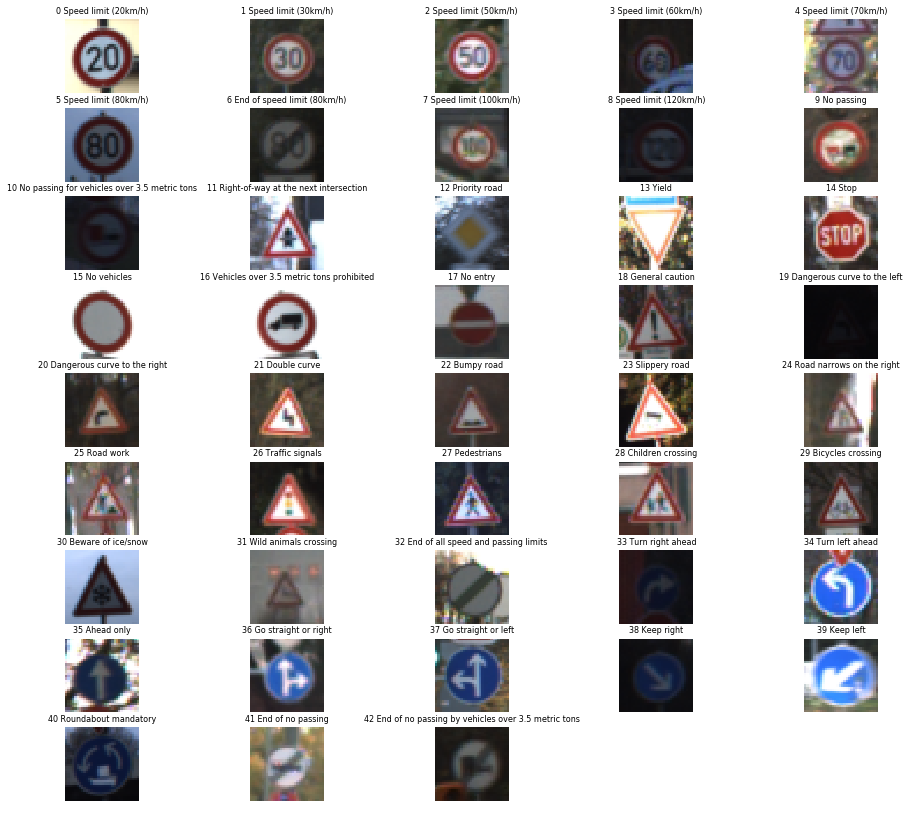

In [25]:
sn = pd.read_csv('signnames.csv')
signnames = list(sn.SignName)
#indices = []

def show_image(location, title, img):
    plt.subplot(*location)
    plt.title(title,fontsize=8)
    plt.axis('off')
    if len(img.shape) == 3:
        plt.imshow(img)
    else:
        plt.imshow(img, cmap='gray')

plt.figure(figsize=(16,16))
for sign_index in range(n_classes + 1):
    [image_index] = random.sample(list(np.where(y_train == sign_index)[0]),1)
    show_image((10, 5, sign_index+1), str(sign_index) + " " + signnames[sign_index], X_train[image_index])
    #indices += [[signnames[sign_index], image_index]]
plt.title("Examples from Raw Training Data")
plt.show()
plt.close()

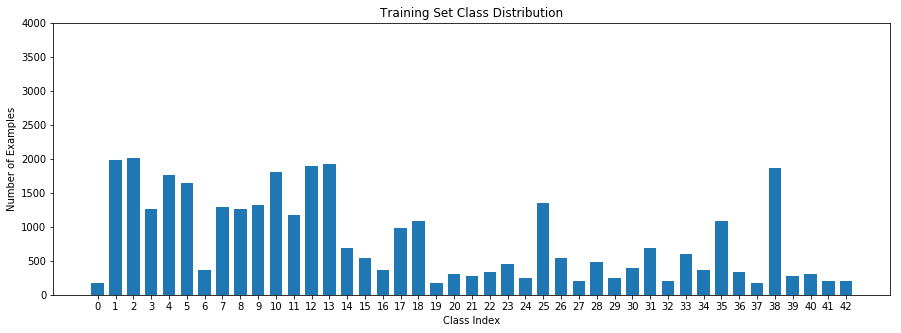

In [26]:
plt.figure(figsize=(15,5))
classes, counts = np.unique(y_train,return_counts=True)
plt.bar(classes, counts, width=0.7, align='center')
plt.ylabel('Number of Examples')
plt.xlabel('Class Index')
plt.xticks(np.arange(0, 43, 1.0))
plt.ylim([0,4000])
plt.title('Training Set Class Distribution')
plt.show()

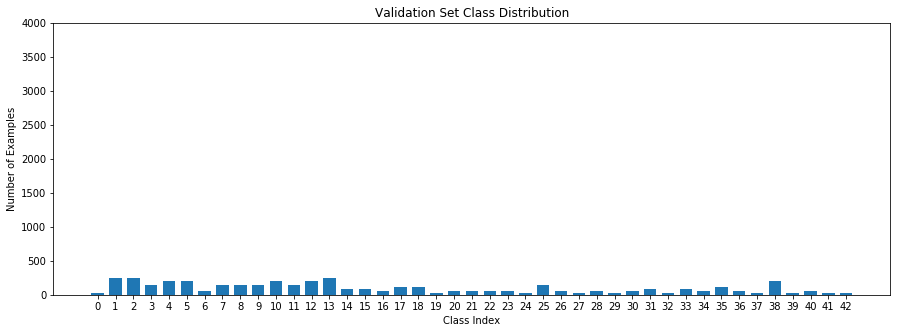

In [22]:
plt.figure(figsize=(15,5))
classes, counts = np.unique(y_valid,return_counts=True)
plt.bar(classes, counts, width=0.7, align='center')
plt.ylabel('Number of Examples')
plt.xlabel('Class Index')
plt.xticks(np.arange(0, 43, 1.0))
plt.ylim([0,4000])
plt.title('Validation Set Class Distribution')
plt.show()

## Step 2: Design and Test a Model Architecture

### Pre-process the Data Set (normalization, grayscale, etc.)

In [18]:
def preprocessing(X_train):
    # image preprocessing
    # grayscaling
    import cv2
    import numpy as np
    os.system("taskset -p 0xff %d" % os.getpid())
    X_train_gray = X_train[:, :, :, 0]
    for i in range(X_train.shape[0]):
        X_train_gray[i, :, :] = cv2.cvtColor(X_train[i, :, :, :], cv2.COLOR_RGB2GRAY)
    # contrast limited adaptive histogram equalization
    #clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    X_train_preproc = X_train_gray
    #for i in range(X_train.shape[0]):
    #    X_train_preproc[i, :, :] = clahe.apply(X_train_preproc[i, :, :])
    # normalize image intensities
    X_train_preproc = (X_train_preproc / 255) - 0.5  # normalize intensity
    return X_train_preproc.reshape((X_train_preproc.shape[0], 32, 32, 1))


def augment(X, y, n_classes):
    def rnd_blur(image):
        kernel = random.randint(0,5)
        if kernel == 0 or kernel == 2:
            return image
        if kernel == 1:
            return cv2.GaussianBlur(image, (1, 1), 0)
        if kernel == 3:
            return cv2.GaussianBlur(image, (3, 3), 0)
        if kernel == 5:
            return cv2.GaussianBlur(image, (5, 5), 0)
        if kernel == 4:
            return cv2.GaussianBlur(image, (7, 7), 0)

    def rnd_brightness(image):
        scale = np.random.rand(1)[0] * 0.4 + 0.8  # random scale betw 0.8 and 1.2
        return image * scale

    def rnd_trans(image):
        x = np.round(np.random.rand(1)[0] * 4 - 2)  # random pixel value between -2 and 2
        y = np.round(np.random.rand(1)[0] * 4 - 2)  # random pixel value between -2 and 2
        matrix = np.array([[1, 0, x], [0, 1, y]])
        new_image = cv2.warpAffine(image, matrix, dsize=image.shape)
        # show_image((1, 1, 1), "image", new_image)
        return new_image

    def rnd_rot(image):
        angle = 40 * np.random.rand(1)[0] - 20  # random angle between -20 and 20 degrees
        matrix = cv2.getRotationMatrix2D((16, 16), angle, 1)
        new_image = cv2.warpAffine(image, matrix, dsize=image.shape)
        # show_image((1, 1, 1), "image", new_image)
        return new_image

    def rnd_scale(image):
        scale = np.random.rand(1)[0]*0.4 + 0.8  # random scale betw 0.8 and 1.2
        matrix = cv2.getRotationMatrix2D((16, 16), 0, scale)
        new_image = cv2.warpAffine(image, matrix, dsize=image.shape)
        # show_image((1, 1, 1), "image", new_image)
        return new_image

    def rnd_shear(image):
        cx = 0.5 * np.random.rand(1)[0] - 0.25  # random val betw -0.25 and 0.25
        cy = 0.5 * np.random.rand(1)[0] - 0.25  # random val betw -0.25 and 0.25
        matrix = np.array([[1, cx, 0], [cy, 1, 0]])
        new_image = cv2.warpAffine(image, matrix, dsize=image.shape)
        # show_image((1, 1, 1), "image", new_image)
        return new_image

    X_augmented = X
    y_augmented = y
    for sign_code in range(n_classes + 1):
        image_list = list(np.where(y == sign_code)[0])
        if len(image_list) < 1000:  # augment the classes that have few examples
            print("augmenting class", sign_code, " of ", n_classes)
            for image_index in image_list:
                # add 4 extra randomly perturbed images to dataset
                image = X[image_index, :, :].reshape(32, 32)
                #helpers.show_image((1, 1, 1), "normal", image, 3)
                transformed_image = rnd_scale(rnd_shear(rnd_rot(rnd_trans(rnd_blur(rnd_brightness(image))))))
                #helpers.show_image((1, 1, 1), "transformed", transformed_image, 3)
                transformed_image = transformed_image.reshape(1, 32, 32, 1)
                X_augmented = np.concatenate((X_augmented, transformed_image))
                y_augmented = np.concatenate((y_augmented, np.array([sign_code])))

                transformed_image = rnd_scale(rnd_shear(rnd_rot(rnd_trans(rnd_blur(rnd_brightness(image))))))
                #helpers.show_image((1, 1, 1), "transformed", transformed_image, 3)
                transformed_image = transformed_image.reshape(1, 32, 32, 1)
                X_augmented = np.concatenate((X_augmented, transformed_image))
                y_augmented = np.concatenate((y_augmented, np.array([sign_code])))

                transformed_image = rnd_scale(rnd_shear(rnd_rot(rnd_trans(rnd_blur(rnd_brightness(image))))))
                #helpers.show_image((1, 1, 1), "transformed", transformed_image, 3)
                transformed_image = transformed_image.reshape(1, 32, 32, 1)
                X_augmented = np.concatenate((X_augmented, transformed_image))
                y_augmented = np.concatenate((y_augmented, np.array([sign_code])))

                transformed_image = rnd_scale(rnd_shear(rnd_rot(rnd_trans(rnd_blur(rnd_brightness(image))))))
                # helpers.show_image((1, 1, 1), "transformed", transformed_image, 3)
                transformed_image = transformed_image.reshape(1, 32, 32, 1)
                X_augmented = np.concatenate((X_augmented, transformed_image))
                y_augmented = np.concatenate((y_augmented, np.array([sign_code])))
        else:
            for image_index in image_list:
                # add 1 extra randomly perturbed images to dataset
                image = X[image_index, :, :].reshape(32, 32)
                transformed_image = rnd_scale(rnd_shear(rnd_rot(rnd_trans(rnd_blur(rnd_brightness(image)))))).reshape(1, 32, 32, 1)
                X_augmented = np.concatenate((X_augmented, transformed_image))
                y_augmented = np.concatenate((y_augmented, np.array([sign_code])))
    return X_augmented, y_augmented

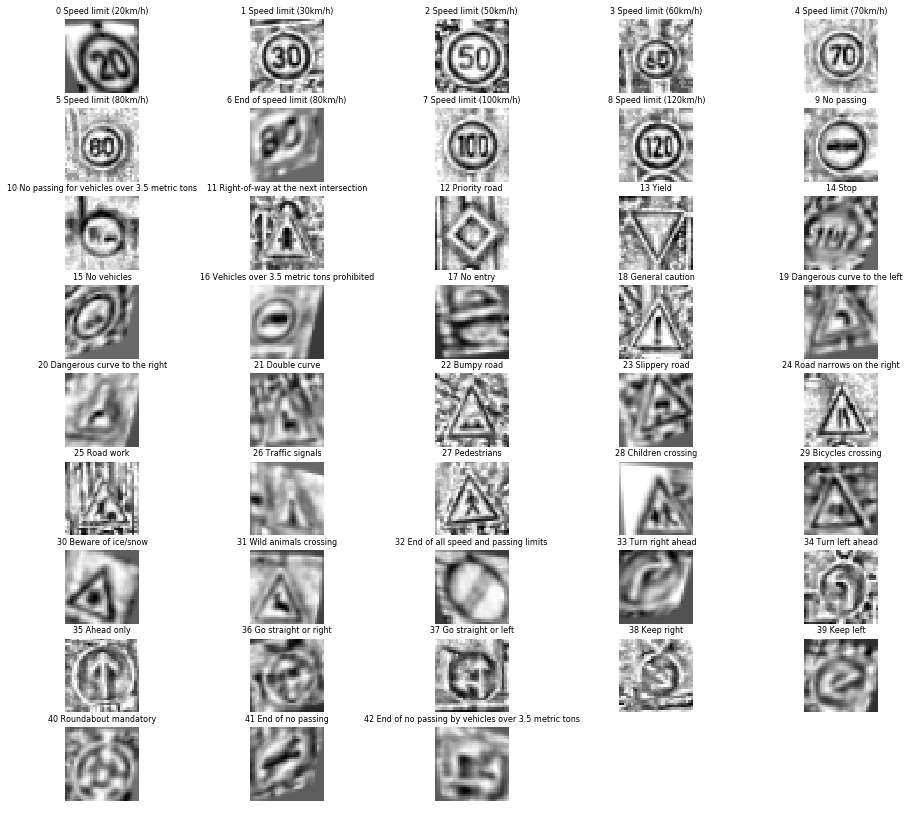

In [19]:
training_file = 'train_preproc_data.p'  # load preprocessed data from disk
validation_file = 'valid_preproc_data.p'  # load preprocessed data from disk
testing_file = 'test_preproc_data.p'  # load preprocessed data from disk

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

plt.figure(figsize=(16,16))
for sign_index in range(n_classes + 1):
    [image_index] = random.sample(list(np.where(y_train == sign_index)[0]),1)
    show_image((10, 5, sign_index+1), str(sign_index) + " " + signnames[sign_index], X_train[image_index].reshape(32,32))
    #indices += [[signnames[sign_index], image_index]]
plt.title("Examples from Preprocessed Training Data")
plt.show()
plt.close()

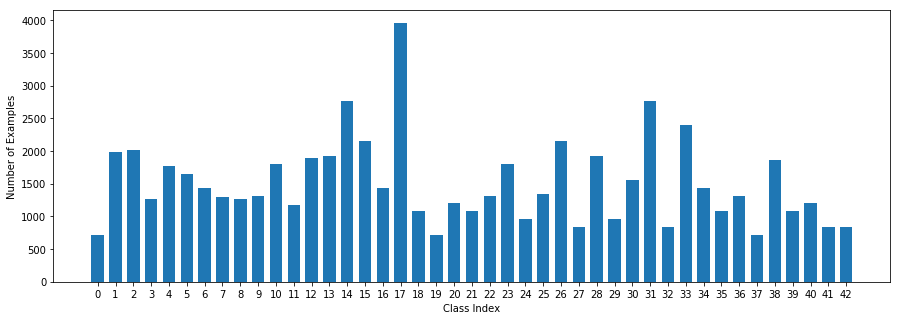

In [20]:
plt.figure(figsize=(15,5))
classes, counts = np.unique(y_train,return_counts=True)
plt.bar(classes, counts, width=0.7, align='center')
plt.ylabel('Number of Examples')
plt.xlabel('Class Index')
plt.xticks(np.arange(0, 43, 1.0))
plt.title("Class Distribution of Augmented Training Set")
plt.show()

### Model Architecture

In [27]:
def MultiScaleCNNArchV2(x, dropout):
    """
    See "Traffic Sign Recognition with MultiScale Convolutional Neural Networks" by Sermanet, 2011.
    See also https://chatbotslife.com/german-sign-classification-using-deep-learning-neural-networks-98-8-solution-d05656bf51ad.
    I re-implemented an architecture similar to the ones described by Yadav and Sermanet. 
    """
    mu = 0
    sigma = 0.05

    # Layer 1: Convolutional. Input = 32x32x1. Output = 32x32x32.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 32), mean=mu, stddev=sigma))
    conv1_b = tf.Variable(tf.zeros(32))
    layer1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='SAME') + conv1_b
    layer1 = tf.nn.relu(layer1)  # activation
    # Layer 2: Convolutional. Input = 32x32x32. Output = 32x32x32.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 32, 32), mean=mu, stddev=sigma))
    conv2_b = tf.Variable(tf.zeros(32))
    layer2 = tf.nn.conv2d(layer1, conv2_W, strides=[1, 1, 1, 1], padding='SAME') + conv2_b
    layer2 = tf.nn.relu(layer2)  # activation
    # Layer 3: Max Pooling. Input = 32x32x32. Output = 16x16x32.
    layer3 = tf.nn.max_pool(layer2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    # Layer 4: Dropout: Input = 16x16x32. Output = 16x16x32.
    layer4 = tf.nn.dropout(layer3, dropout)


    # Layer 5: Convolutional. Input = 16x16x32. Output = 16x16x64.
    conv5_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 32, 64), mean=mu, stddev=sigma))
    conv5_b = tf.Variable(tf.zeros(64))
    layer5 = tf.nn.conv2d(layer4, conv5_W, strides=[1, 1, 1, 1], padding='SAME') + conv5_b
    layer5 = tf.nn.relu(layer5)
    # Layer 6: Convolutional. Input = 16x16x64. Output = 16x16x64.
    conv6_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 64, 64), mean=mu, stddev=sigma))
    conv6_b = tf.Variable(tf.zeros(64))
    layer6 = tf.nn.conv2d(layer5, conv6_W, strides=[1, 1, 1, 1], padding='SAME') + conv6_b
    layer6 = tf.nn.relu(layer6)
    # Layer 7: Max Pooling. Input = 16x16x64. Output = 8x8x64.
    layer7 = tf.nn.max_pool(layer6, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    # Layer 8: Dropout. Input = 8x8x64. Output = 8x8x64.
    layer8 = tf.nn.dropout(layer7, dropout)

    # Layer 9: Convolutional. Input = 8x8x64. Output = 8x8x128.
    conv9_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 64, 128), mean=mu, stddev=sigma))
    conv9_b = tf.Variable(tf.zeros(128))
    layer9 = tf.nn.conv2d(layer8, conv9_W, strides=[1, 1, 1, 1], padding='SAME') + conv9_b
    layer9 = tf.nn.relu(layer9)
    # Layer 10: Convolutional. Input = 8x8x128. Output = 8x8x128.
    conv10_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 128, 128), mean=mu, stddev=sigma))
    conv10_b = tf.Variable(tf.zeros(128))
    layer10 = tf.nn.conv2d(layer9, conv10_W, strides=[1, 1, 1, 1], padding='SAME') + conv10_b
    layer10 = tf.nn.relu(layer10)
    # Layer 11: Max Pooling: Input = 8x8x128. Output = 4x4x128.
    layer11 = tf.nn.max_pool(layer10, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    # Layer 12: Dropout. Input = 4x4x128. Output = 4x4x128.
    layer12 = tf.nn.dropout(layer11, dropout)

    # Layer 13: Combining layers 4, 8, and 12 into one flattened layer.
    # Input = 16x16x32, 8x8x64, 4x4x128. Output = 1x14336
    flat_layer4 = tf.contrib.layers.flatten(layer4)
    flat_layer8 = tf.contrib.layers.flatten(layer8)
    flat_layer12 = tf.contrib.layers.flatten(layer12)
    layer13 = tf.concat([flat_layer4, flat_layer8, flat_layer12], axis=1)
    # Layer 14: Fully Connected. Input = 1x14336. Output = 1x1024
    fc14_W = tf.Variable(tf.truncated_normal(shape=(14336, 1024), mean=mu, stddev=sigma))
    fc14_b = tf.Variable(tf.zeros(1024))
    layer14 = tf.matmul(layer13, fc14_W) + fc14_b
    layer14 = tf.nn.relu(layer14)
    # Layer 15: Dropout
    layer15 = tf.nn.dropout(layer14, dropout)
    # Layer 16: Fully Connected: Input = 1x1024. Output = 1x1024.
    fc16_W = tf.Variable(tf.truncated_normal(shape=(1024, 1024), mean=mu, stddev=sigma))
    fc16_b = tf.Variable(tf.zeros(1024))
    layer16 = tf.matmul(layer15, fc16_W) + fc16_b
    layer16 = tf.nn.relu(layer16)
    # Layer 17: Dropout
    layer17 = tf.nn.dropout(layer16, dropout)
    # Layer 18: Fully Connected: Input = 1x1024. Output = 1x42.
    fc18_W = tf.Variable(tf.truncated_normal(shape=(1024, 42), mean=mu, stddev=sigma))
    fc18_b = tf.Variable(tf.zeros(42))
    layer18 = tf.matmul(layer17, fc18_W) + fc18_b

    regularizers = (tf.nn.l2_loss(conv1_W)
                    + tf.nn.l2_loss(conv2_W) + tf.nn.l2_loss(conv5_W)
                    + tf.nn.l2_loss(conv6_W) + tf.nn.l2_loss(conv9_W)
                    + tf.nn.l2_loss(conv10_W) + tf.nn.l2_loss(fc14_W)
                    + tf.nn.l2_loss(fc16_W) + tf.nn.l2_loss(fc18_W))

    return layer18, regularizers

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [17]:
import tensorflow as tf
import sklearn as skl

# Hyperparameters
EPOCHS = 15
BATCH_SIZE = 128
rate = 0.0002
dropout = 0.50

# Set up TensorFlow input and output
x = tf.placeholder(tf.float32, (None, 32, 32, 1))  # floats for normalized data
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 42)
keep_prob = tf.placeholder(tf.float32)
logits, regularizers = architecture.MultiScaleCNNArch(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy) + 1e-5 * regularizers
optimizer = tf.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)
# model evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

# training
max_accuracy = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = X_train.shape[0]

    print("Training with batch size ", BATCH_SIZE)
    print()
    for i in range(EPOCHS):
        X_train, y_train = skl.utils.shuffle(X_train, y_train)
        # process each batch
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            _, loss = sess.run([training_operation, loss_operation], feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})  # execute session
        validation_accuracy = helpers.evaluate(X_valid, y_valid, accuracy_operation, BATCH_SIZE, x, y, keep_prob)
        print("EPOCH {} ...".format(i + 1), " validation accuracy = {:.3f}".format(validation_accuracy))
        if validation_accuracy > max_accuracy:  # save only highest accuracy we've achieved so far
            max_accuracy = validation_accuracy
            saver.save(sess, './best_model_save_file')
            print("Highest accuracy seen so far. Model saved.")
        else:
            print("Not highest accuracy seen so far. Model not saved.")
        print()
        

Training with batch size  128

Model saved.
EPOCH 1 ...
Validation Accuracy = 0.687

Model saved.
EPOCH 2 ...
Validation Accuracy = 0.871

Model saved.
EPOCH 3 ...
Validation Accuracy = 0.896



ValueError: GraphDef cannot be larger than 2GB.

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Predict the Sign Type for Each Image

In [3]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

### Analyze Performance

In [4]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [3]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")